In [2]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [3]:
### PARAMETERS
products = ["btc", "eth"]
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    dataframes[product]["volume_imbalance"] = (dataframes[product]["bid_vol_price_sum"] - dataframes[product]["ask_vol_price_sum"]) / (dataframes[product]["bid_vol_price_sum"] + dataframes[product]["ask_vol_price_sum"])

    # Normalize
    # scalers[product] = MinMaxScaler()
    scalers[product] = StandardScaler()
    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

x1.head()

,bid_price_min,bid_price_q1,bid_price_median,bid_price_q3,bid_price_max,bid_price_mean,bid_price_std,ask_price_min,ask_price_q1,ask_price_median,...,ask_vol_price_max,ask_vol_price_mean,ask_vol_price_std,spread_min,spread_btwn_means,spread_btwn_medians,spread_btwn_vol_sums,spread_btwn_vol_means,spread_btwn_vol_medians,volume_imbalance
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132,-1.538257
0.028059,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132,-1.538257
0.057995,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132,-1.538257
0.069528,0.0,-1.654911,-2.167061,-2.287315,-1.457464,-1.978842,-0.133305,-1.456733,-1.708529,-0.878765,...,-2.384186e-07,-0.753204,-0.782867,0.106285,2.284703,0.527346,1.692915,-0.784846,3.043683,-1.541446
0.130339,0.0,-1.654911,-2.167061,-2.287315,-1.457464,-1.978842,-0.133305,-1.456733,-1.708529,-0.878765,...,-2.384186e-07,-0.753204,-0.782867,0.106285,2.284703,0.527346,1.692915,-0.784846,3.043683,-1.541446


### Add volume imbalance to data

In [12]:
target = "ask_price_min"

In [13]:
lags = [1, 5, 10]
for lag in lags:
    # x1[f'{target}_lag_{lag}'] = x2[target].shift(-lag)
    x1[f'{target}_lag_{lag}'] = x2[target].shift(lag)


In [14]:
# drop_idx = np.append(x1.loc[x1[target] < -6].index.values, x2.loc[x2[target] < -6].index.values)

In [15]:
# x1 = x1.drop(index=drop_idx)
# x2 = x2.drop(index=drop_idx)

In [16]:
pred_shift = 5 # Try to predict observation that will happen in 5 observations

# x = x1.iloc[pred_shift:len(x1)-max(lags)]
# y = x2.iloc[:len(x2)-max(lags)][target].shift(-pred_shift).dropna()
x = x1.iloc[max(lags):len(x1)-pred_shift]
y = x2.iloc[max(lags):len(x2)][target].shift(-pred_shift).dropna()


print(f"x.shape={x.shape}, y.shape={y.shape}")

x.shape=(24974, 43), y.shape=(24974,)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Train model

## SVR

In [18]:
# Initialize SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model on training data
svr_model.fit(x_train, y_train)

# Predictions on test data
y_pred_svr = svr_model.predict(x_test)

# Learning takes 2 seconds ??

In [19]:
# Model evaluation
svr_rmse = root_mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)
print(f"Mean Squared Error (MSE): {svr_rmse:.6f}")
print(f"R-squared (R2): {svr_r2:.6f}")


Mean Squared Error (MSE): 0.049839
R-squared (R2): 0.997537


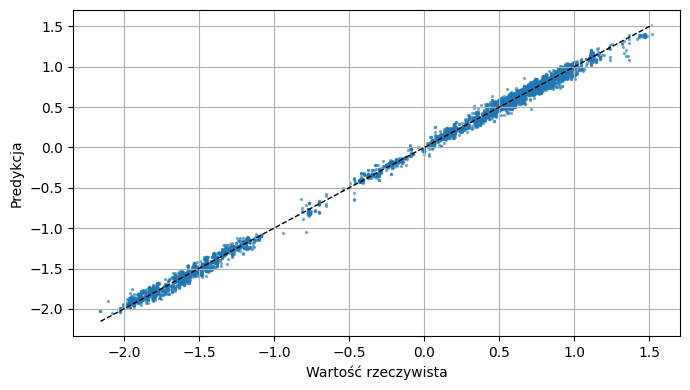

In [20]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_test, y_pred_svr, marker='o', s=2, alpha=0.5)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=1)
plt.xlabel("Wartość rzeczywista")
plt.ylabel("Predykcja")
plt.title("")
plt.grid(True)
plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"svr_actual_predicted_{target}.pdf"))

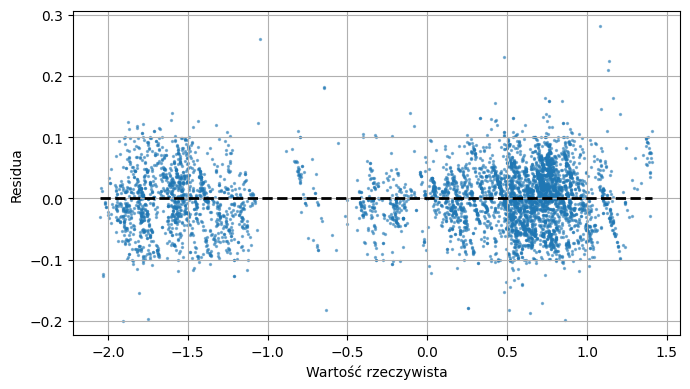

In [21]:
residuals_svr = y_test - y_pred_svr

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_pred_svr, residuals_svr, marker='o', s=2, alpha=0.5)
ax.plot([min(y_pred_svr), max(y_pred_svr)], [0, 0], 'k--', lw=2)
plt.xlabel("Wartość rzeczywista")
plt.ylabel("Residua")
plt.title("")
plt.grid(True)
fig.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"svr_residua_{target}.pdf"))

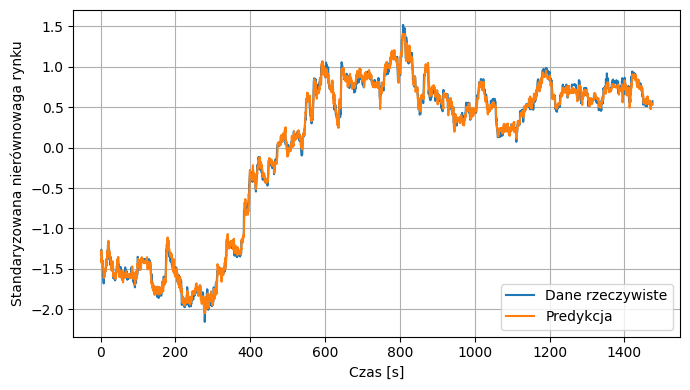

In [22]:
y_test_sorted = y_test.sort_index()
y_pred_sorted = pd.Series(y_pred_svr, index=y_test.index).sort_index()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(y_test_sorted.index, y_test_sorted.values, label="Dane rzeczywiste")
ax.plot(y_pred_sorted.index, y_pred_sorted.values, label="Predykcja")
plt.xlabel("Czas [s]")
plt.ylabel("Standaryzowana nierównowaga rynku")
plt.legend(loc='lower right')
plt.grid(True)
fig.tight_layout()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"svr_predictions_{target}.pdf"))

In [456]:
alert_cnt = 0
alert_percent = 0.6
alert_times = []

for i, y_pred_svr_val in enumerate(y_pred_svr):
    target_val_lag_1 = x_test[f'{target}_lag_{lags[0]}'].iloc[i]
    target_change = np.abs(y_pred_svr_val - target_val_lag_1) / np.abs(target_val_lag_1)

    # print(target_val_lag_1, y_test.iloc[i], y_pred_svr_val, target_change)
    if target_change > alert_percent:
        alert_cnt += 1
        alert_times.append(y_test.index[i])

print(alert_cnt)

568


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\4291966115.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  y_test_sorted = y_test.sort_index()[plot_start:plot_end]
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\4291966115.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  y_pred_sorted = pd.Series(y_pred_svr, index=y_test.index).sort_index()[plot_start:plot_end]
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\4291966115.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  x_tes

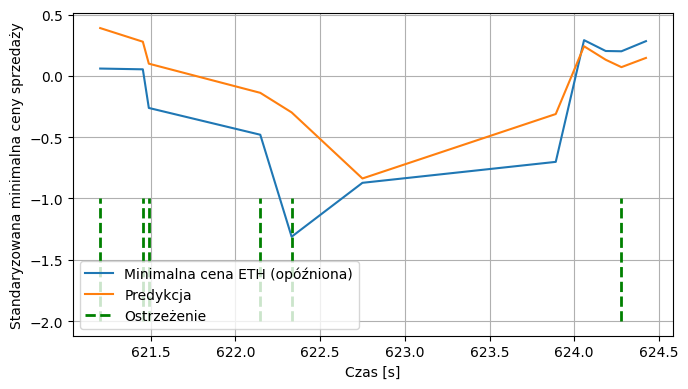

In [459]:
plot_start = 620
plot_end = 625
y_test_sorted = y_test.sort_index()[plot_start:plot_end]
y_pred_sorted = pd.Series(y_pred_svr, index=y_test.index).sort_index()[plot_start:plot_end]
x_test_sorted = x_test.sort_index()[plot_start:plot_end]

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_test_sorted.index, x_test_sorted[f'{target}_lag_1'], label="Minimalna cena ETH (opóźniona)")
ax.plot(y_pred_sorted.index, y_pred_sorted.values, label="Predykcja")

min_val = min(min(y_test.values), min(y_pred_svr))
max_val = max(max(y_test.values), max(y_pred_svr))

plot_label = True
for time in alert_times:
    if plot_start < time < plot_end and time != 180.178109: 
        if plot_label:
            ax.plot([time, time], [-2, -1], 'g--', label="Ostrzeżenie", lw=2)
            plot_label = False
        else:
            ax.plot([time, time], [-2, -1], 'g--', lw=2) 

plt.legend(loc="lower left")
plt.xlabel("Czas [s]")
plt.ylabel("Standaryzowana minimalna ceny sprzedaży")
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"svr_price_alerts_{target}.pdf"))

In [324]:
for i, val in enumerate(alert_times):
    if 180 < val < 182:
        print(val)

180.210894
180.178109


## Random Forest Regressor

In [460]:
from sklearn.ensemble import RandomForestRegressor

In [461]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

# Learning takes 1min 10,6 s

In [462]:
# Model evaluation
rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE): {rf_rmse:.6f}")
print(f"R-squared (R2): {rf_r2:.6f}")

Mean Squared Error (MSE): 0.206779
R-squared (R2): 0.957178


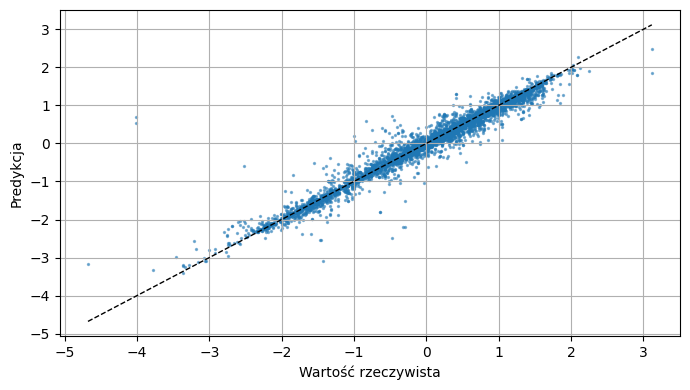

In [463]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_test, y_pred_rf, marker='o', s=2, alpha=0.5)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=1)
plt.xlabel("Wartość rzeczywista")
plt.ylabel("Predykcja")
plt.title("")
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(data_path, "..", "graphics", f"rf_actual_predicted_{target}.pdf"))

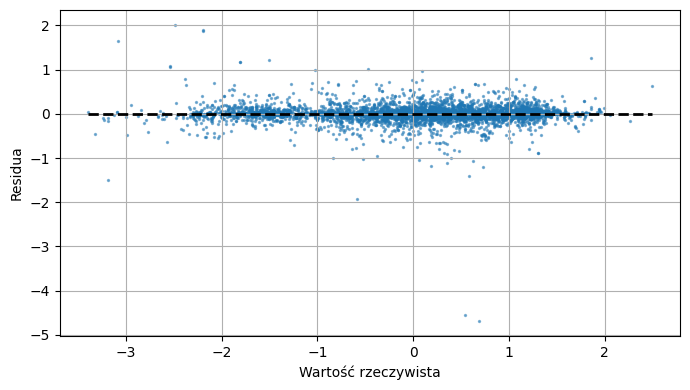

In [464]:
residuals_rf = y_test - y_pred_rf

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_pred_rf, residuals_rf, marker='o', s=2, alpha=0.5)
ax.plot([min(y_pred_rf), max(y_pred_rf)], [0, 0], 'k--', lw=2)
plt.xlabel("Wartość rzeczywista")
plt.ylabel("Residua")
plt.title("")
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(data_path, "..", "graphics", f"rf_residua_{target}.pdf"))

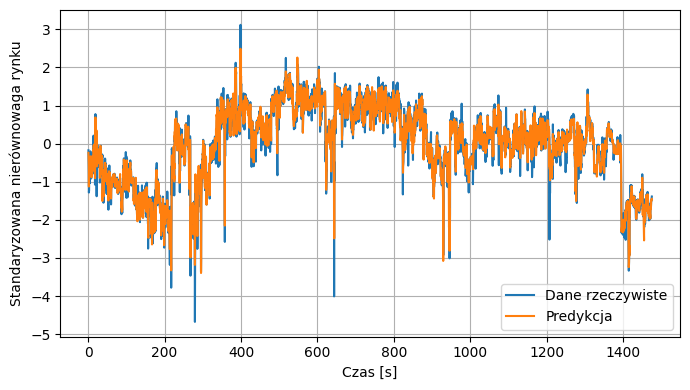

In [471]:
y_test_sorted = y_test.sort_index()
y_pred_rf_sorted = pd.Series(y_pred_rf, index=y_test.index).sort_index()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(y_test_sorted.index, y_test_sorted.values, label="Dane rzeczywiste")
ax.plot(y_pred_rf_sorted.index, y_pred_rf_sorted.values, label="Predykcja")
plt.legend()
plt.xlabel("Czas [s]")
plt.ylabel("Standaryzowana nierównowaga rynku")
plt.legend(loc='lower right')
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"rf_predictions_{target}.pdf"))

In [467]:
alert_cnt = 0
alert_percent = 0.8
alert_times = []

for i, y_pred_rf_val in enumerate(y_pred_rf):
    target_val_lag_1 = x_test[f'{target}_lag_{lags[0]}'].iloc[i]
    target_change = np.abs(y_pred_rf_val - target_val_lag_1) / np.abs(target_val_lag_1)

    # print(target_val_lag_1, y_test.iloc[i], y_pred_svr_val, target_change)
    if target_change > alert_percent:
        alert_cnt += 1
        alert_times.append(y_test.index[i])

print(alert_cnt)

620


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\2635270506.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  y_test_sorted = y_test.sort_index()[plot_start:plot_end]
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\2635270506.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  y_pred_sorted = pd.Series(y_pred_rf, index=y_test.index).sort_index()[plot_start:plot_end]
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_6840\2635270506.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  x_test

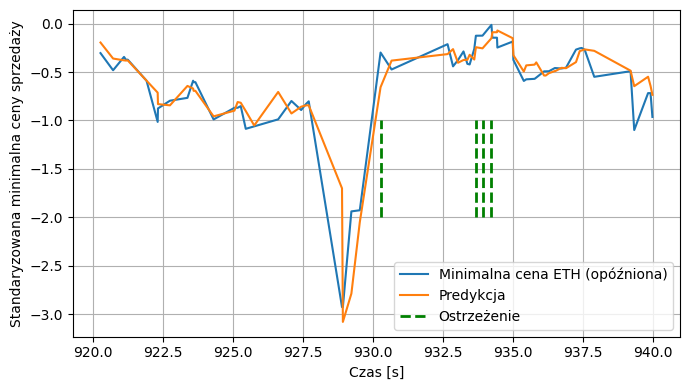

In [469]:
plot_start = 920
plot_end = 940
y_test_sorted = y_test.sort_index()[plot_start:plot_end]
y_pred_sorted = pd.Series(y_pred_rf, index=y_test.index).sort_index()[plot_start:plot_end]
x_test_sorted = x_test.sort_index()[plot_start:plot_end]

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_test_sorted.index, x_test_sorted[f'{target}_lag_1'], label="Minimalna cena ETH (opóźniona)")
ax.plot(y_pred_sorted.index, y_pred_sorted.values, label="Predykcja")

min_val = min(min(y_test.values), min(y_pred_svr))
max_val = max(max(y_test.values), max(y_pred_svr))

plot_label = True
for time in alert_times:
    if plot_start < time < plot_end and time != 180.178109: 
        if plot_label:
            ax.plot([time, time], [-2, -1], 'g--', label="Ostrzeżenie", lw=2)
            plot_label = False
        else:
            ax.plot([time, time], [-2, -1], 'g--', lw=2) 

plt.legend(loc="best")
plt.xlabel("Czas [s]")
plt.ylabel("Standaryzowana minimalna ceny sprzedaży")
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"rf_price_alerts_{target}.pdf"))